In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [3]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    FormFactorFile,
    ParametersContainer,
    create_compound,
    load_reflectivity_scans,
    ReflectivityScan,
    EnergyScan, load_energy_scans,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
plot_density_profile_atoms_layers
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import fit_differential_evolution, FitContext, FitTransform, TVRegularizer

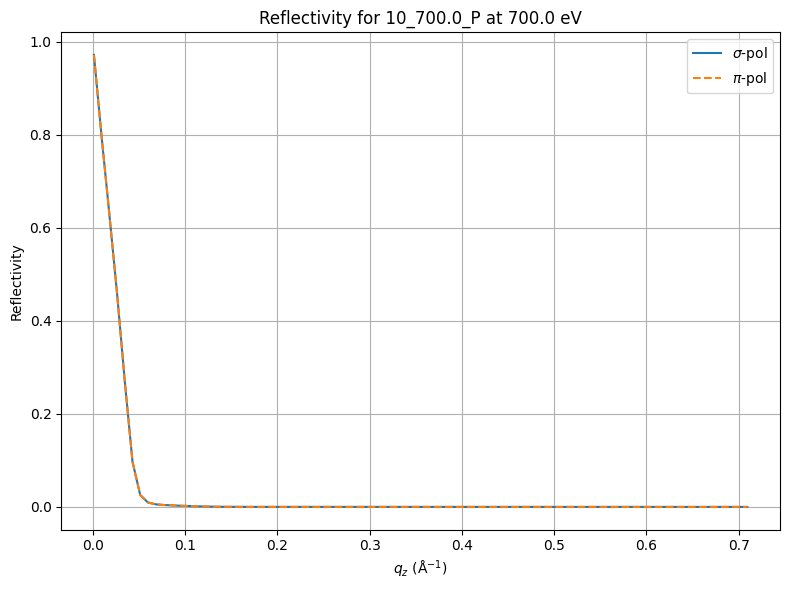

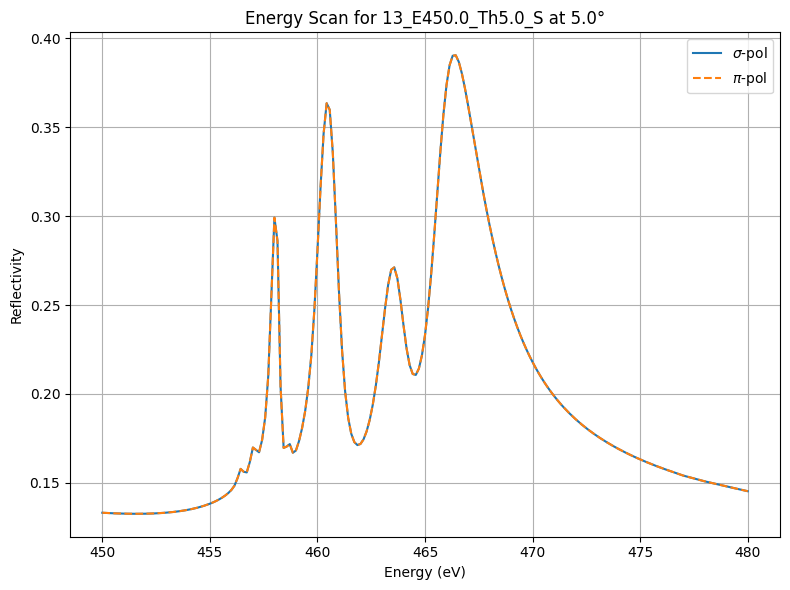

In [4]:
from rxrmask.core import ReflectivityScan, EnergyScan
import h5py

data_file = h5py.File('/Users/niaggar25/Developer/mitacs/GO-RXR/DOCS/Tutorial/example1.h5', 'r')
experiment = data_file['Experimental_data']

RS = experiment['Reflectivity_Scan']
ES = experiment['Energy_Scan']

ref_scans = []
ene_scans = []

for Rkey in RS.keys():
    data = RS[Rkey]
    qz = data[0, :]
    r = data[2, :]
    dat = ReflectivityScan(
        name=Rkey,
        energy_eV=float(data.attrs['Energy']),
        pol=data.attrs['Polarization'].lower(),
        qz=qz,
        R=r,
        bounds=[(qz[0], qz[-1])],
        weights=[1]
    )
    ref_scans.append(dat)

for Ekey in ES.keys():
    data = ES[Ekey]
    e = data[3, :]
    r = data[2, :]
    dat = EnergyScan(
        name=Ekey,
        theta_deg=float(data.attrs['Angle']),
        pol=data.attrs['Polarization'].lower(),
        E_eV=e,
        R=r,
        bounds=[(e[0], e[-1])],
        weights=[1]
    )
    ene_scans.append(dat)

test_scan = ref_scans[0]
plot_reflectivity(test_scan.qz, test_scan.R, test_scan.R, test_scan.energy_eV, test_scan.name)

test_scan_ene = ene_scans[0]
plot_energy_scan(test_scan_ene.E_eV, test_scan_ene.R, test_scan_ene.R, test_scan_ene.theta_deg, test_scan_ene.name)




In [5]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False, offset=-1.1)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False, offset=0.5)
la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)
x1_atom = Atom(
    Z=0,
    name="X1",
    ff=c_ff,
)
x2_atom = Atom(
    Z=0,
    name="X2",
    ff=c_ff,
)

In [6]:
def print_parameters(params_container):
    params_vals = params_container.get_fit_vector()
    print(f"Current params: {params_vals}")
    for param in params_container.parameters:
        if param.fit:
            print(f"{param.name}: {param.value}")

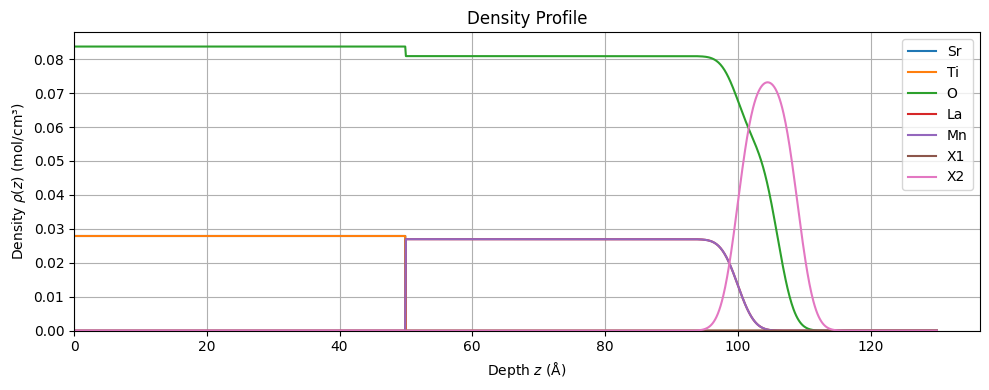

In [9]:
parameters_container = ParametersContainer()
substrate = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3-crystal",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=0.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
layer1 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:1,Mn:1,O:3",
    thickness=50.0,
    density=6.52,
    atoms=[la_atom, mn_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)
layer2 = create_compound(
    parameters_container=parameters_container,
    name="CCO",
    formula="X1:1,X2:1,O:1",
    thickness=10.0,
    density=5,
    atoms=[x1_atom, x2_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

layer2.compound_details[0].molar_density.independent = True
layer2.compound_details[0].molar_density.set(0.0)
layer2.compound_details[0].molar_density.set_bounds(0.0, 0.0)
layer2.compound_details[1].molar_density.independent = True
layer2.compound_details[1].molar_density.set(0.075)
layer2.compound_details[1].molar_density.set_bounds(0.065, 0.090)
layer2.compound_details[2].molar_density.independent = True
layer2.compound_details[2].molar_density.set(0.055)
layer2.compound_details[2].molar_density.set_bounds(0.045, 0.065)

layer2.compound_details[0].thickness.independent = True
layer2.compound_details[0].thickness.set(15.0)
layer2.compound_details[0].thickness.set_bounds(14.0, 16.0)
layer2.compound_details[1].thickness.independent = True
layer2.compound_details[1].thickness.set(9.0)
layer2.compound_details[1].thickness.set_bounds(7.0, 11.0)
layer2.compound_details[2].thickness.independent = True
layer2.compound_details[2].thickness.set(6.0)
layer2.compound_details[2].thickness.set_bounds(4.0, 8.0)

layer2.compound_details[0].roughness.independent = True
layer2.compound_details[0].roughness.set(0.0)
layer2.compound_details[0].roughness.set_bounds(0.0, 0.0)
layer2.compound_details[1].roughness.independent = True
layer2.compound_details[1].roughness.set(4.0)
layer2.compound_details[1].roughness.set_bounds(2.0, 6.0)
layer2.compound_details[2].roughness.independent = True
layer2.compound_details[2].roughness.set(4.0)
layer2.compound_details[2].roughness.set_bounds(2.0, 6.0)

struc = Structure(name="SrTiO3-struc", n_compounds=3, params_container=parameters_container)
struc.add_compound(0, substrate)
struc.add_compound(1, layer1)
struc.add_compound(2, layer2)
struc.validate_compounds()
struc.create_layers(step=0.1)

plot_density_profile_atoms_layers(struc.atoms_layers)


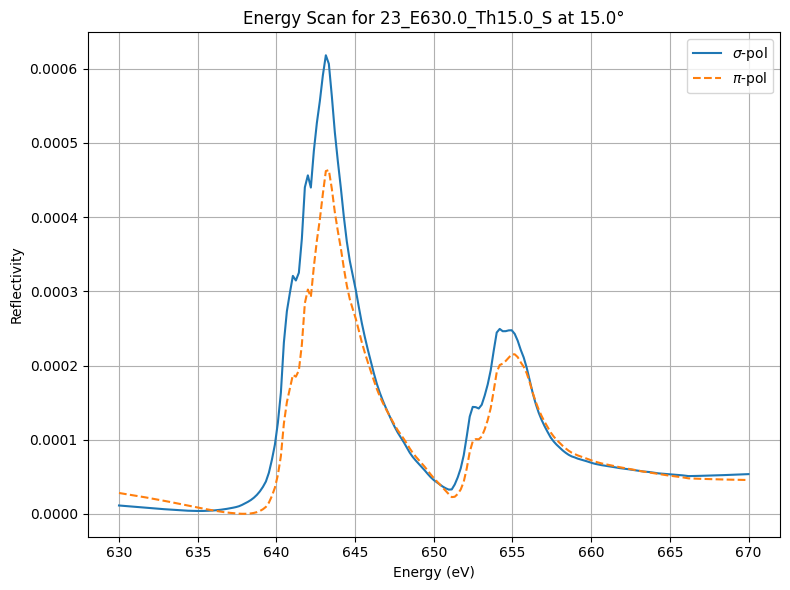

In [10]:
backend = PRReflectivityBackend(als=True)

test_scan_data = None
for e in ene_scans:
    if e.name == '23_E630.0_Th15.0_S':
        test_scan_data = e

test_en_scan = backend.compute_energy_scan(struc, test_scan_data.E_eV, test_scan_data.theta_deg)
plot_energy_scan(test_scan_data.E_eV, test_scan_data.R, test_en_scan.R_s, test_scan_data.theta_deg, test_scan_data.name)

SrTiO3-crystal-Sr-roughness
0.0 0.0 0.2
SrTiO3-crystal-Ti-roughness
0.0 0.0 0.2
SrTiO3-crystal-O-roughness
0.0 0.0 0.2
LaMnO3-thickness
50.0 40.0 60.0
LaMnO3-La-roughness
4.0 3.2 4.8
LaMnO3-Mn-roughness
4.0 3.2 4.8
LaMnO3-O-roughness
4.0 3.2 4.8
CCO-X2-molar_density
0.075 0.065 0.09
CCO-X2-thickness
9.0 7.0 11.0
CCO-X2-roughness
4.0 2.0 6.0
CCO-O-molar_density
0.055 0.045 0.065
CCO-O-thickness
6.0 4.0 8.0
CCO-O-roughness
4.0 2.0 6.0


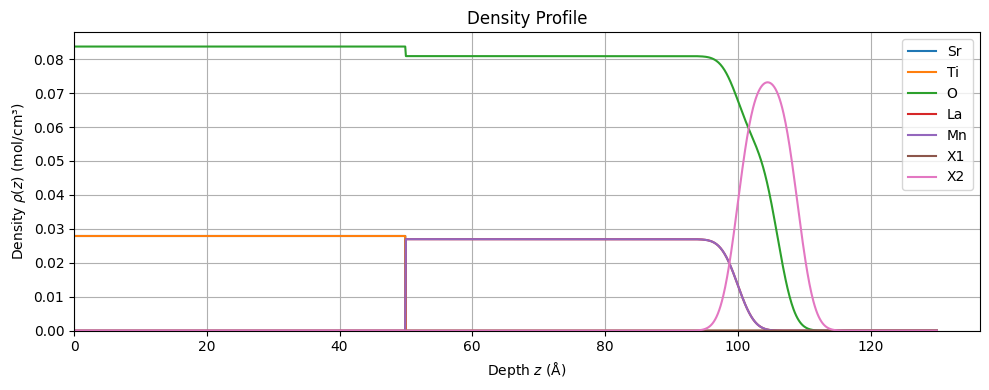

In [12]:
substrate.compound_details[0].roughness.independent = True
substrate.compound_details[0].roughness.fit = True
substrate.compound_details[1].roughness.independent = True
substrate.compound_details[1].roughness.fit = True
substrate.compound_details[2].roughness.independent = True
substrate.compound_details[2].roughness.fit = True



layer1.compound_details[0].roughness.independent = True
layer1.compound_details[0].roughness.fit = True
layer1.compound_details[1].roughness.independent = True
layer1.compound_details[1].roughness.fit = True
layer1.compound_details[2].roughness.independent = True
layer1.compound_details[2].roughness.fit = True
layer1.thickness.fit = True


layer2.compound_details[1].roughness.independent = True
layer2.compound_details[1].roughness.fit = True
layer2.compound_details[2].roughness.independent = True
layer2.compound_details[2].roughness.fit = True
layer2.compound_details[1].molar_density.independent = True
layer2.compound_details[1].molar_density.fit = True
layer2.compound_details[2].molar_density.independent = True
layer2.compound_details[2].molar_density.fit = True
layer2.compound_details[1].thickness.independent = True
layer2.compound_details[1].thickness.fit = True
layer2.compound_details[2].thickness.independent = True
layer2.compound_details[2].thickness.fit = True

struc.update_layers()

for par in parameters_container.parameters:
    if par.fit:
        print(par.name)
        print(par.get(), par.lower, par.upper)

plot_density_profile_atoms_layers(struc.atoms_layers)

differential_evolution step 1: f(x)= 6349.3172533075785
differential_evolution step 2: f(x)= 2118.4309212322823
differential_evolution step 3: f(x)= 2110.5634307731857
differential_evolution step 4: f(x)= 2110.5634307731857
differential_evolution step 5: f(x)= 2110.5634307731857
differential_evolution step 6: f(x)= 2110.5634307731857
differential_evolution step 7: f(x)= 2110.5634307731857
differential_evolution step 8: f(x)= 2110.5634307731857
differential_evolution step 9: f(x)= 2110.5634307731857
differential_evolution step 10: f(x)= 1489.0575319872532
differential_evolution step 11: f(x)= 1037.7800298847094
differential_evolution step 12: f(x)= 1037.7800298847094
differential_evolution step 13: f(x)= 1037.7800298847094
differential_evolution step 14: f(x)= 1037.7800298847094
differential_evolution step 15: f(x)= 873.9712346541588
differential_evolution step 16: f(x)= 206.38629798510723
differential_evolution step 17: f(x)= 115.86549566914358
differential_evolution step 18: f(x)= 92.

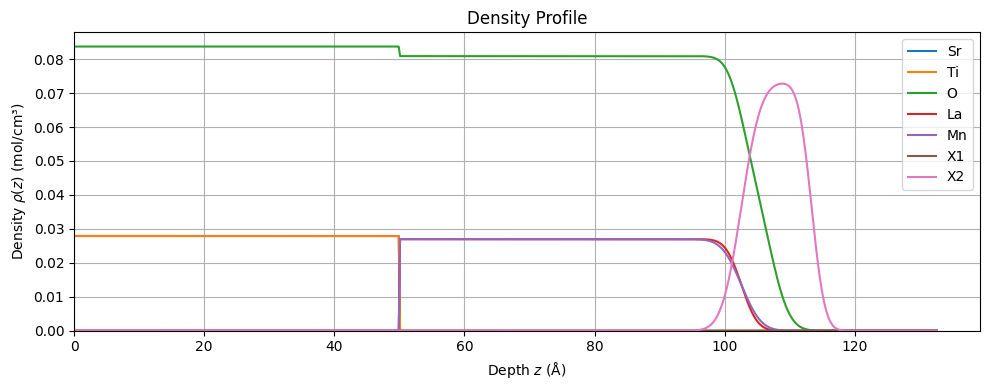

In [13]:
scale_param = parameters_container.new_parameter("scale", value=1.0, fit=True)
scale_param.upper = 1.0
scale_param.lower = 0.0
offset_param = parameters_container.new_parameter("offset", value=0.0, fit=True)
offset_param.upper = 2.0
offset_param.lower = 0

context = FitContext(
    backend=backend,
    structure=struc,
    transform=FitTransform(r_scale="ln", sim_scale=scale_param, sim_offset=offset_param),
    tv=TVRegularizer(),
    objective="chi2",
)

names = ['1_400.0_S', '3_500.0_S', '5_455.0_S', '7_642.0_S', '9_700.0_S', '11_833.0_S']
fits_ref_scans = []
for ref_scan in ref_scans:
    if ref_scan.name in names:
        fits_ref_scans.append(ref_scan)


parameters = [param for param in parameters_container.parameters if param.fit]

res = fit_differential_evolution(
    params=parameters,
    ctx=context,
    ref_scans=fits_ref_scans,
    en_scans=[],
)

print(res)
print("Final parameters:")
print_parameters(parameters_container)
plot_density_profile_atoms_layers(struc.atoms_layers)

In [ ]:
 for par in parameters:
    print(par.name)
    print(par.get(), par.lower, par.upper)

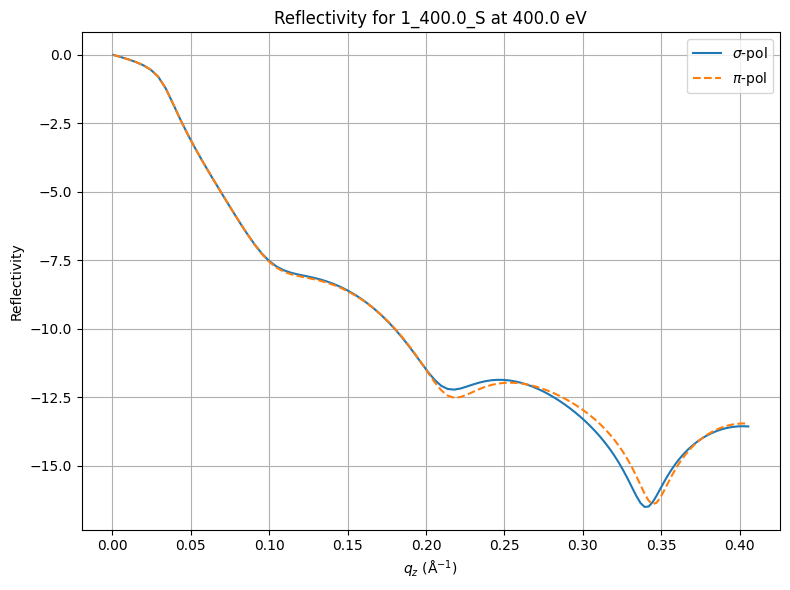

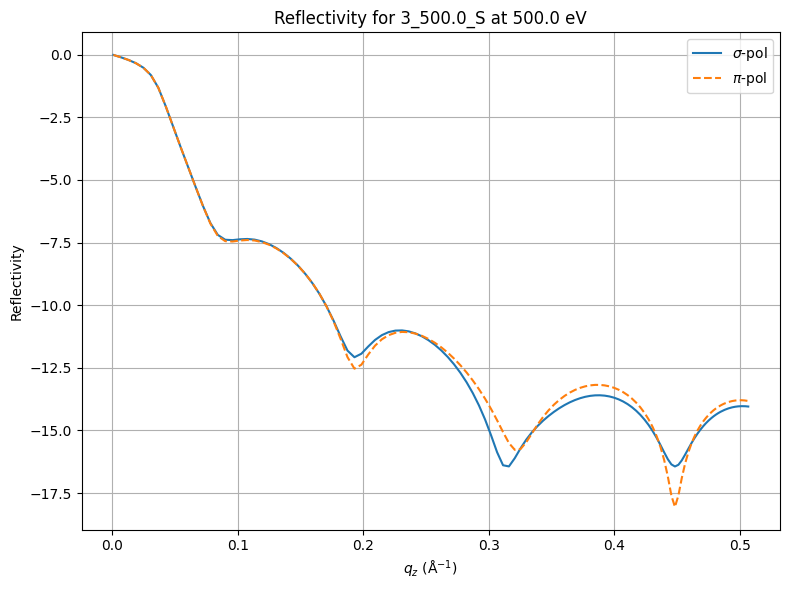

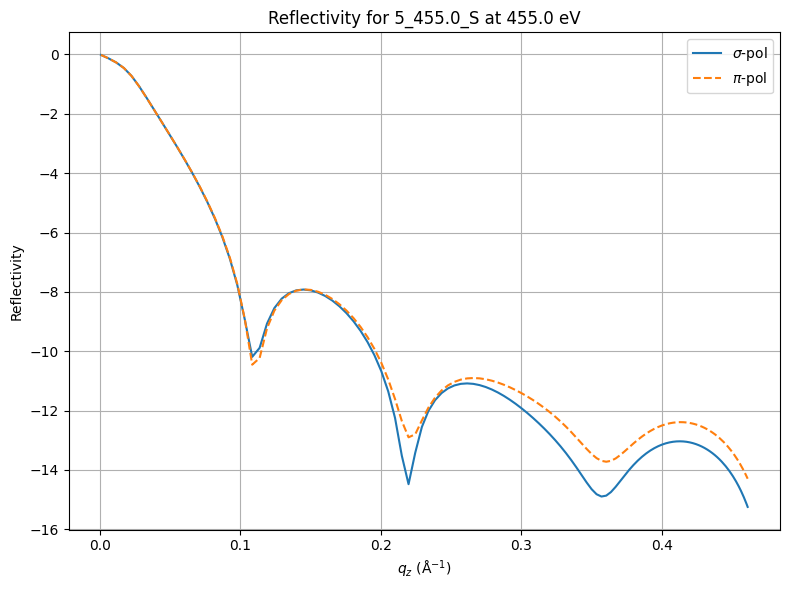

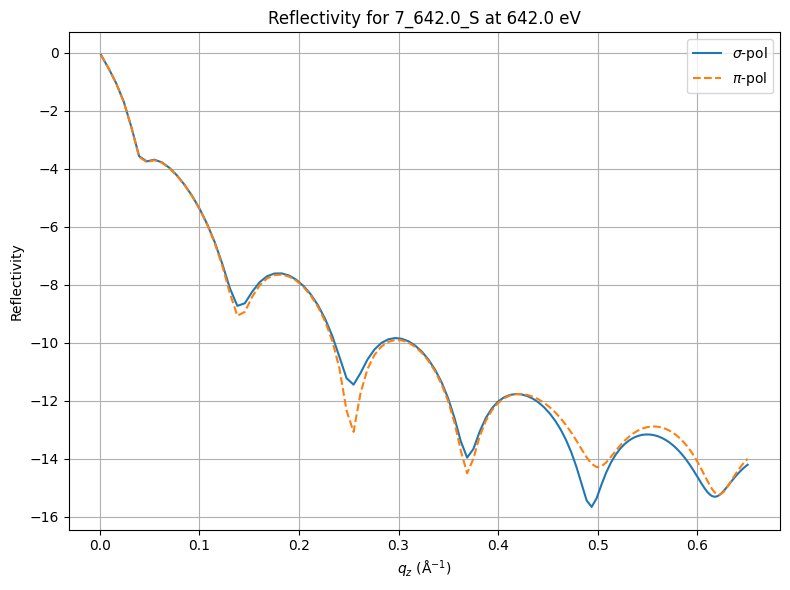

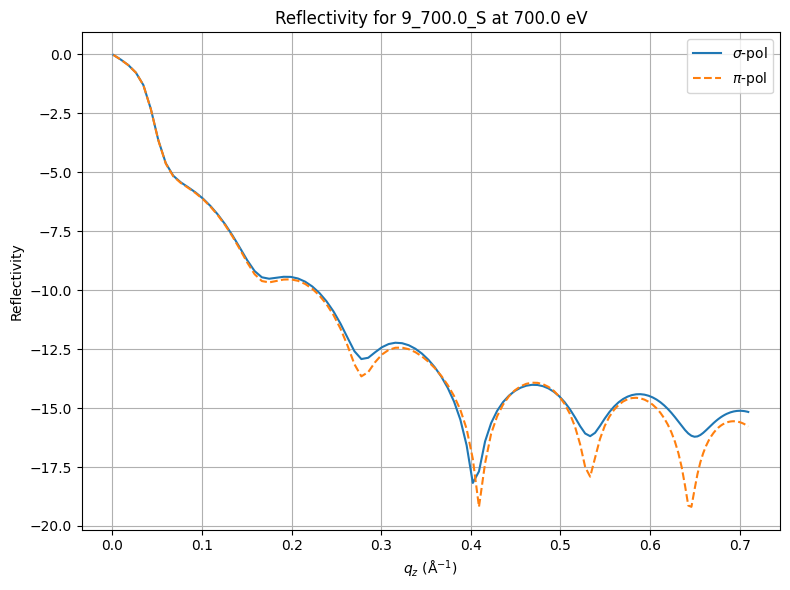

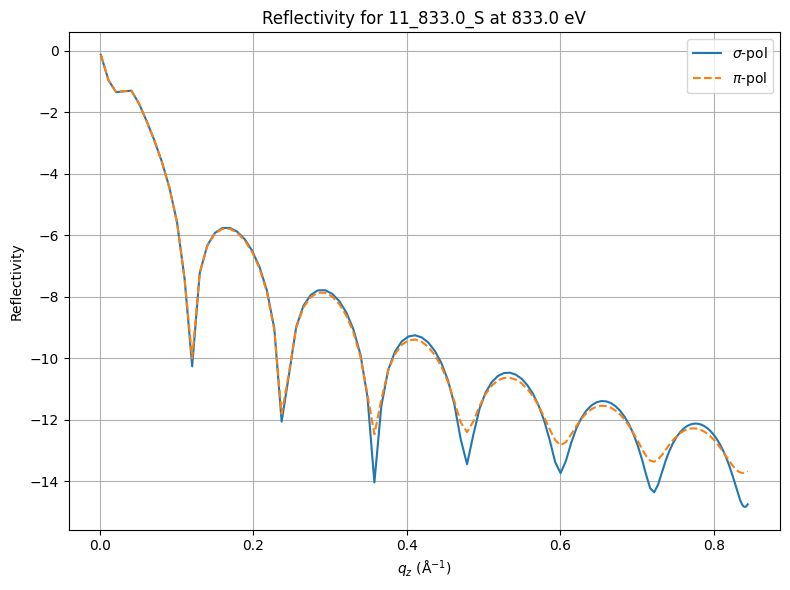

In [14]:
backend = PRReflectivityBackend(als=True)

for name in names:
    test_scan = None
    for e in fits_ref_scans:
        if e.name == name:
            test_scan = e

    test_en_scan = backend.compute_reflectivity(struc, test_scan.qz, test_scan.energy_eV)
    plot_reflectivity(test_scan.qz, test_scan.R, np.log(test_en_scan.R_s), test_scan.energy_eV, test_scan.name)